## Time Series Forecasting with XGBoost

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
df_0 = pd.read_csv('./data/7832_battery.csv')
df_0.head()

,v_bat,battery_soc,temperature,box_id,event_time
0,70.92,58.43,34.59,7832,2024-11-06 14:01:41
1,70.92,58.43,34.59,7832,2024-11-06 14:01:41
2,70.92,58.43,34.59,7832,2024-11-06 14:01:41
3,70.92,58.43,34.59,7832,2024-11-06 14:01:41
4,70.92,58.50,34.56,7832,2024-11-06 14:00:42


In [3]:
df_0['box_id'].unique()

array([7832])

In [5]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26584 entries, 0 to 26583
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   v_bat        26584 non-null  float64
 1   battery_soc  26584 non-null  float64
 2   temperature  26584 non-null  float64
 3   box_id       26584 non-null  int64  
 4   event_time   26584 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 1.0+ MB


In [6]:
df_0.describe()

,v_bat,battery_soc,temperature,box_id
count,26584.000000,26584.000000,26584.000000,26584.0
mean,81.014837,73.127283,34.311100,7832.0
std,11.054354,22.020947,3.544261,0.0
min,54.420000,3.630000,27.860000,7832.0
25%,73.170000,62.562500,32.110000,7832.0
50%,81.250000,76.905000,34.240000,7832.0
75%,90.170000,91.180000,36.112500,7832.0
max,98.500000,100.000000,48.620000,7832.0


In [7]:
df_0.isna().sum()

v_bat          0
battery_soc    0
temperature    0
box_id         0
event_time     0
dtype: int64

In [8]:
# df_0[['v_bat', 'battery_soc', 'temperature']].ffill(inplace=True)
# data.fillna({'v_bat': 'ffill', 'battery_soc': 'ffill', 'temperature': 'ffill'}, inplace=True)

In [9]:
def calculate_vol(v_bat):
    return (((v_bat/100) * 1200) + 3000)/1000

def calculate_soc(Vnormalized):
    return 112 - 112/(1 + ((1.9*Vnormalized)**2.9))

def calculate_soc_2(Vnormalized):
    return 270 - 270/((1 + ((3.5 * Vnormalized)**8))**0.045)

def normalize(voltage):
    return (voltage - min_vol) / (max_vol - min_vol)

max_vol = 4.2
min_vol = 3

df = (df_0
      .assign(vol=lambda x: x['v_bat'].apply(calculate_vol))
      .assign(Vnormalized=lambda x: x['vol'].apply(normalize))
      .assign(soc=lambda x: x['Vnormalized'].apply(calculate_soc))
      .assign(soc_2=lambda x: x['Vnormalized'].apply(calculate_soc_2)))
df.head()

,v_bat,battery_soc,temperature,box_id,event_time,vol,Vnormalized,soc,soc_2
0,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
1,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
2,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
3,70.92,58.43,34.59,7832,2024-11-06 14:01:41,3.85104,0.7092,78.812187,75.370364
4,70.92,58.50,34.56,7832,2024-11-06 14:00:42,3.85104,0.7092,78.812187,75.370364


In [10]:
df.isna().sum()

v_bat          0
battery_soc    0
temperature    0
box_id         0
event_time     0
vol            0
Vnormalized    0
soc            0
soc_2          0
dtype: int64

In [11]:
df = df.set_index('event_time')
df.head()

,v_bat,battery_soc,temperature,box_id,vol,Vnormalized,soc,soc_2
event_time,,,,,,,,
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:01:41,70.92,58.43,34.59,7832,3.85104,0.7092,78.812187,75.370364
2024-11-06 14:00:42,70.92,58.50,34.56,7832,3.85104,0.7092,78.812187,75.370364


In [12]:
df = df[['box_id', 'temperature', 'vol', 'battery_soc', 'soc', 'soc_2']]

In [13]:
df.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-06 14:01:41,7832,34.59,3.85104,58.43,78.812187,75.370364
2024-11-06 14:01:41,7832,34.59,3.85104,58.43,78.812187,75.370364
2024-11-06 14:01:41,7832,34.59,3.85104,58.43,78.812187,75.370364
2024-11-06 14:01:41,7832,34.59,3.85104,58.43,78.812187,75.370364
2024-11-06 14:00:42,7832,34.56,3.85104,58.50,78.812187,75.370364


In [14]:
df.isna().sum()

box_id         0
temperature    0
vol            0
battery_soc    0
soc            0
soc_2          0
dtype: int64

In [15]:
df.index = pd.to_datetime(df.index)
# df.sort_values('event_time', ascending=True)
df.sort_index(inplace=True)
df.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-02 13:34:10,7832,31.28,3.96,64.33,86.357805,83.627556
2024-11-02 13:34:20,7832,31.28,3.96,64.33,86.357805,83.627556
2024-11-02 13:34:23,7832,31.28,3.96,64.33,86.357805,83.627556
2024-11-02 13:34:23,7832,31.28,3.96,64.33,86.357805,83.627556
2024-11-02 13:34:23,7832,31.28,3.96,64.33,86.357805,83.627556


In [16]:
df.isna().sum()

box_id         0
temperature    0
vol            0
battery_soc    0
soc            0
soc_2          0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26584 entries, 2024-11-02 13:34:10 to 2024-11-06 14:01:41
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   box_id       26584 non-null  int64  
 1   temperature  26584 non-null  float64
 2   vol          26584 non-null  float64
 3   battery_soc  26584 non-null  float64
 4   soc          26584 non-null  float64
 5   soc_2        26584 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.4 MB


In [18]:
df.describe()

,box_id,temperature,vol,battery_soc,soc,soc_2
count,26584.0,26584.000000,26584.000000,26584.000000,26584.000000,26584.000000
mean,7832.0,34.311100,3.972178,73.127283,85.656237,83.572387
std,0.0,3.544261,0.132652,22.020947,8.588300,9.669092
min,7832.0,27.860000,3.653040,3.630000,58.711212,55.950755
25%,7832.0,32.110000,3.878040,62.562500,80.887748,77.545173
50%,7832.0,34.240000,3.975000,76.905000,87.235923,84.664640
75%,7832.0,36.112500,4.082040,91.180000,92.572514,91.484908
max,7832.0,48.620000,4.182000,100.000000,96.350407,97.073622


In [19]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

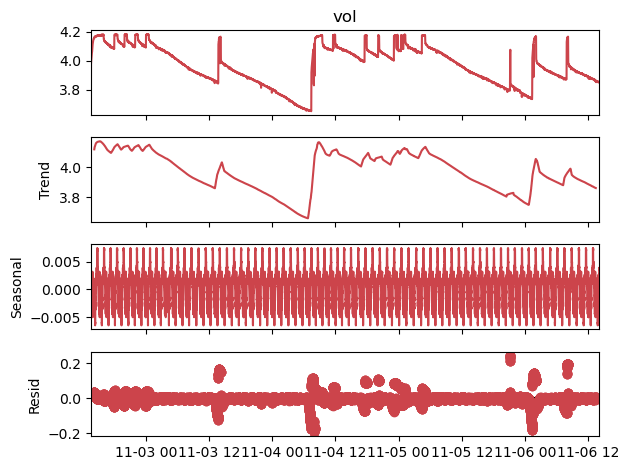

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['vol'], period=365).plot()
plt.show()

In [21]:
va = df.resample('T').mean()
va.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-02 13:34:00,7832.0,31.280000,3.96000,64.330000,86.357805,83.627556
2024-11-02 13:35:00,7832.0,31.504444,3.84304,48.088889,76.902486,73.881657
2024-11-02 13:36:00,7832.0,34.880000,3.98004,72.810000,87.523125,85.008249
2024-11-02 13:37:00,7832.0,35.980000,3.99000,72.940000,88.079383,85.680280
2024-11-02 13:38:00,7832.0,37.030000,3.99696,73.150000,88.459348,86.144465


In [22]:
va.tail()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-06 13:57:00,7832.0,34.54,3.85296,58.72,78.964605,75.528089
2024-11-06 13:58:00,7832.0,34.56,3.85296,58.60,78.964605,75.528089
2024-11-06 13:59:00,7832.0,34.55,3.85296,58.57,78.964605,75.528089
2024-11-06 14:00:00,7832.0,34.56,3.85104,58.50,78.812187,75.370364
2024-11-06 14:01:00,7832.0,34.59,3.85104,58.43,78.812187,75.370364


In [23]:
va.isna().sum(), va.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5788 entries, 2024-11-02 13:34:00 to 2024-11-06 14:01:00
Freq: T
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   box_id       5569 non-null   float64
 1   temperature  5569 non-null   float64
 2   vol          5569 non-null   float64
 3   battery_soc  5569 non-null   float64
 4   soc          5569 non-null   float64
 5   soc_2        5569 non-null   float64
dtypes: float64(6)
memory usage: 316.5 KB


(box_id         219
 temperature    219
 vol            219
 battery_soc    219
 soc            219
 soc_2          219
 dtype: int64,
 None)

In [24]:
va = va.ffill()
# df_ip = df.resample('T').mean().interpolate(method='linear')

In [25]:
va.isna().sum(), va.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5788 entries, 2024-11-02 13:34:00 to 2024-11-06 14:01:00
Freq: T
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   box_id       5788 non-null   float64
 1   temperature  5788 non-null   float64
 2   vol          5788 non-null   float64
 3   battery_soc  5788 non-null   float64
 4   soc          5788 non-null   float64
 5   soc_2        5788 non-null   float64
dtypes: float64(6)
memory usage: 316.5 KB


(box_id         0
 temperature    0
 vol            0
 battery_soc    0
 soc            0
 soc_2          0
 dtype: int64,
 None)

In [26]:
va.isna().sum()

box_id         0
temperature    0
vol            0
battery_soc    0
soc            0
soc_2          0
dtype: int64

In [27]:
def voltage_average(data, window):
    actual = data['vol'][-(window+30):]
    va = data['vol'].rolling(window).mean()[-(window+30):]
    
    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    va.plot(label='VA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('Last {}-Minutes Voltage Average'.format(str(window)), weight='bold', fontsize=20)
    plt.legend()

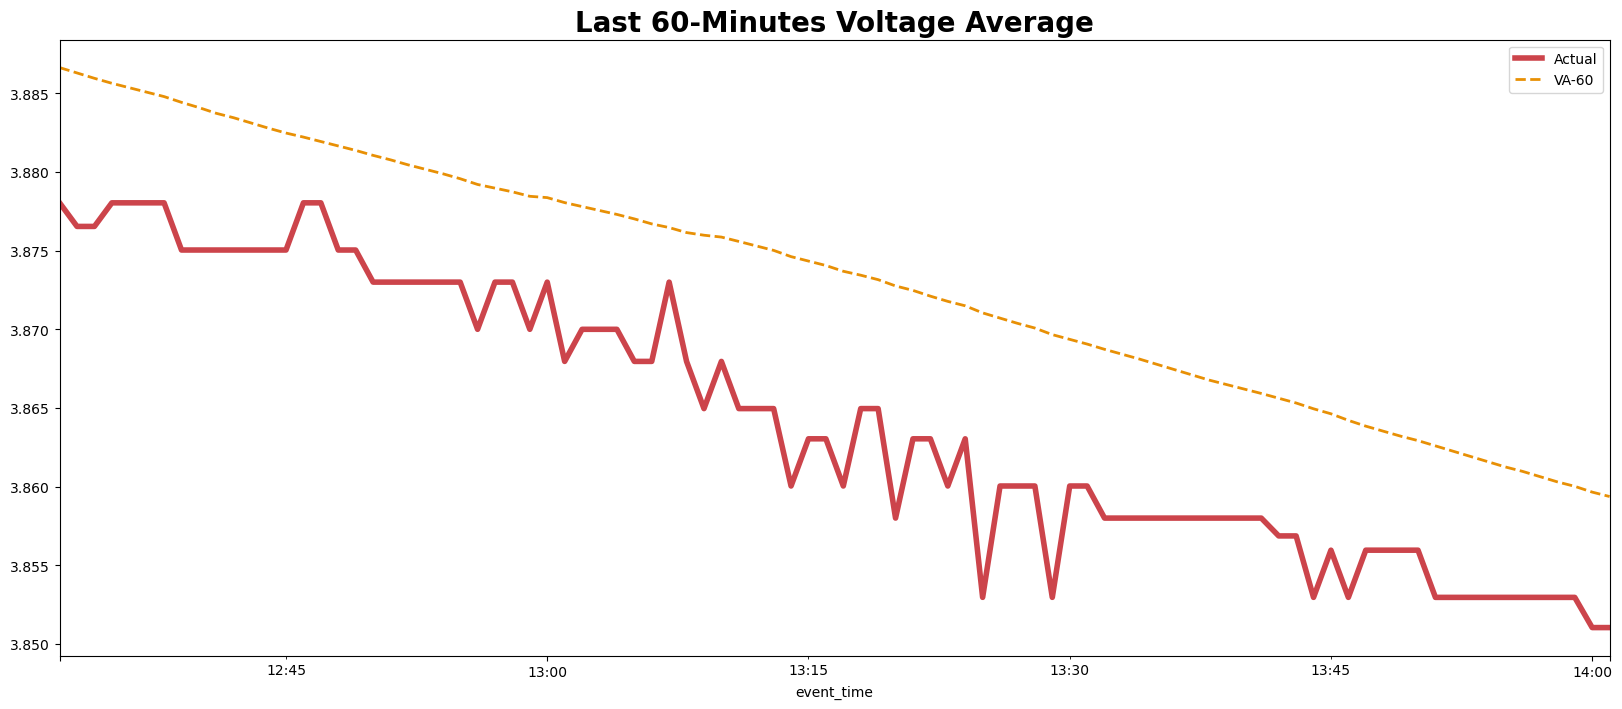

In [28]:
voltage_average(va, 60)

In [29]:
def soc_average(data, window):
    actual = data['soc'][-(window+30):]
    va = data['soc'].rolling(window).mean()[-(window+30):]
    
    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    va.plot(label='SA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('Last {}-Minutes SoC Average'.format(str(window)), weight='bold', fontsize=20)
    plt.legend()

### Train / Test Split

In [31]:
split_date = '2024-11-06'
vol_train = va.loc[va.index <= split_date].copy()
vol_test = va.loc[va.index > split_date].copy()

In [32]:
# df_train, df_test = va[va.index < '2024-11-06'], va[va.index >= '2024-11-06']

In [33]:
print('Train:\t', len(vol_train))
print('Test:\t', len(vol_test))

Train:	 4947
Test:	 841


In [36]:
vol_train.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-02 13:34:00,7832.0,31.280000,3.96000,64.330000,86.357805,83.627556
2024-11-02 13:35:00,7832.0,31.504444,3.84304,48.088889,76.902486,73.881657
2024-11-02 13:36:00,7832.0,34.880000,3.98004,72.810000,87.523125,85.008249
2024-11-02 13:37:00,7832.0,35.980000,3.99000,72.940000,88.079383,85.680280
2024-11-02 13:38:00,7832.0,37.030000,3.99696,73.150000,88.459348,86.144465


In [37]:
vol_test.head()

,box_id,temperature,vol,battery_soc,soc,soc_2
event_time,,,,,,
2024-11-06 00:01:00,7832.0,35.07,3.76500,35.63,71.173609,67.765795
2024-11-06 00:02:00,7832.0,35.08,3.76500,35.57,71.173609,67.765795
2024-11-06 00:03:00,7832.0,35.08,3.76296,35.43,70.972495,67.571617
2024-11-06 00:04:00,7832.0,35.05,3.76296,35.32,70.972495,67.571617
2024-11-06 00:05:00,7832.0,35.00,3.75996,35.21,70.675000,67.284788


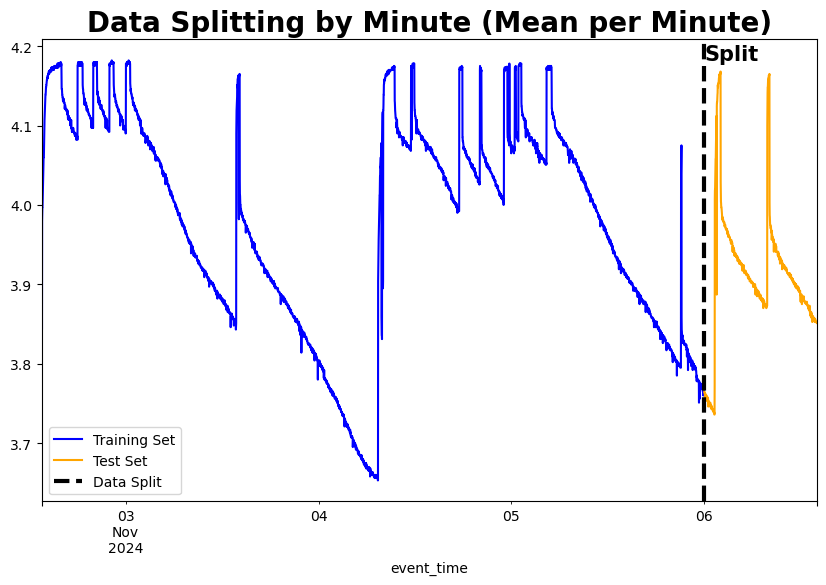

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))

vol_train['vol'].plot(label='Training Set', color='blue')
vol_test['vol'].plot(label='Test Set', color='orange')

split_date = pd.to_datetime('2024-11-05 23:59:59')
plt.axvline(split_date, color='black', ls='--', lw=3, label='Data Split')

plt.text(split_date, vol_train['vol'].max(), 'Split', fontsize=15, fontweight='bold')

plt.xlim(vol_train.index.min(), vol_test.index.max())

plt.title('Data Splitting by Minute (Mean per Minute)', weight='bold', fontsize=20)
plt.legend(loc='best')  

plt.show()


In [39]:
# _ = vol_test \
#     .rename(columns={'vol': 'TEST SET'}) \
#     .join(vol_train.rename(columns={'vol': 'TRAINING SET'}), how='outer') \
#     .plot(figsize=(15,5), title='Voltage', style='.')

In [40]:
vol_train.index.min(), vol_train.index.max()

(Timestamp('2024-11-02 13:34:00'), Timestamp('2024-11-06 00:00:00'))

In [41]:
vol_test.index.min(), vol_test.index.max()

(Timestamp('2024-11-06 00:01:00'), Timestamp('2024-11-06 14:01:00'))

## Building Models

## 2. XGBoost

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm

The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems

To be able to use XGBoost for time series forecasting, the data should be transformed into supervised learning before feeding it into the model

Official Documentation: [Here](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

Helpful Resources:

 - https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
 - https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost


In [48]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [50]:
X_train, y_train = create_features(vol_train, label='vol')
X_test, y_test = create_features(vol_test, label='vol')

In [51]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
event_time,,,,,,,,
2024-11-02 13:34:00,13,5,4,11,2024,307,2,44
2024-11-02 13:35:00,13,5,4,11,2024,307,2,44
2024-11-02 13:36:00,13,5,4,11,2024,307,2,44
2024-11-02 13:37:00,13,5,4,11,2024,307,2,44
2024-11-02 13:38:00,13,5,4,11,2024,307,2,44


In [52]:
vol_train.head()

,box_id,temperature,vol,battery_soc,soc,soc_2,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
event_time,,,,,,,,,,,,,,,
2024-11-02 13:34:00,7832.0,31.280000,3.96000,64.330000,86.357805,83.627556,2024-11-02 13:34:00,13,5,4,11,2024,307,2,44
2024-11-02 13:35:00,7832.0,31.504444,3.84304,48.088889,76.902486,73.881657,2024-11-02 13:35:00,13,5,4,11,2024,307,2,44
2024-11-02 13:36:00,7832.0,34.880000,3.98004,72.810000,87.523125,85.008249,2024-11-02 13:36:00,13,5,4,11,2024,307,2,44
2024-11-02 13:37:00,7832.0,35.980000,3.99000,72.940000,88.079383,85.680280,2024-11-02 13:37:00,13,5,4,11,2024,307,2,44
2024-11-02 13:38:00,7832.0,37.030000,3.99696,73.150000,88.459348,86.144465,2024-11-02 13:38:00,13,5,4,11,2024,307,2,44


In [53]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

In [54]:
reg = xgb.XGBRegressor(n_estimators=1000,
                      early_stopping_rounds=50)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [55]:
# xgb_model = XGBRegressor(
#     n_estimators=1000, 
#     learning_rate=0.05, 
#     early_stopping_rounds=10, 
#     eval_metric='mae')

# xgb_model.fit(X_train, y_train, 
#               eval_set=[(X_train, y_train), (X_test, y_test)],
#              verbose=False)

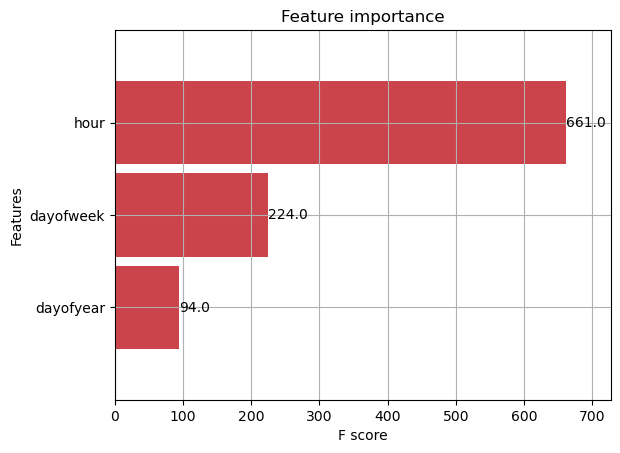

In [56]:
_ = plot_importance(reg, height=0.9)

In [57]:
vol_test.loc[:, 'pred'] = reg.predict(X_test)
voltage = pd.concat([vol_test, vol_train], sort=False)

In [58]:
voltage.head()

,box_id,temperature,vol,battery_soc,soc,soc_2,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,pred
event_time,,,,,,,,,,,,,,,,
2024-11-06 00:01:00,7832.0,35.07,3.76500,35.63,71.173609,67.765795,2024-11-06 00:01:00,0,2,4,11,2024,311,6,45,3.88873
2024-11-06 00:02:00,7832.0,35.08,3.76500,35.57,71.173609,67.765795,2024-11-06 00:02:00,0,2,4,11,2024,311,6,45,3.88873
2024-11-06 00:03:00,7832.0,35.08,3.76296,35.43,70.972495,67.571617,2024-11-06 00:03:00,0,2,4,11,2024,311,6,45,3.88873
2024-11-06 00:04:00,7832.0,35.05,3.76296,35.32,70.972495,67.571617,2024-11-06 00:04:00,0,2,4,11,2024,311,6,45,3.88873
2024-11-06 00:05:00,7832.0,35.00,3.75996,35.21,70.675000,67.284788,2024-11-06 00:05:00,0,2,4,11,2024,311,6,45,3.88873


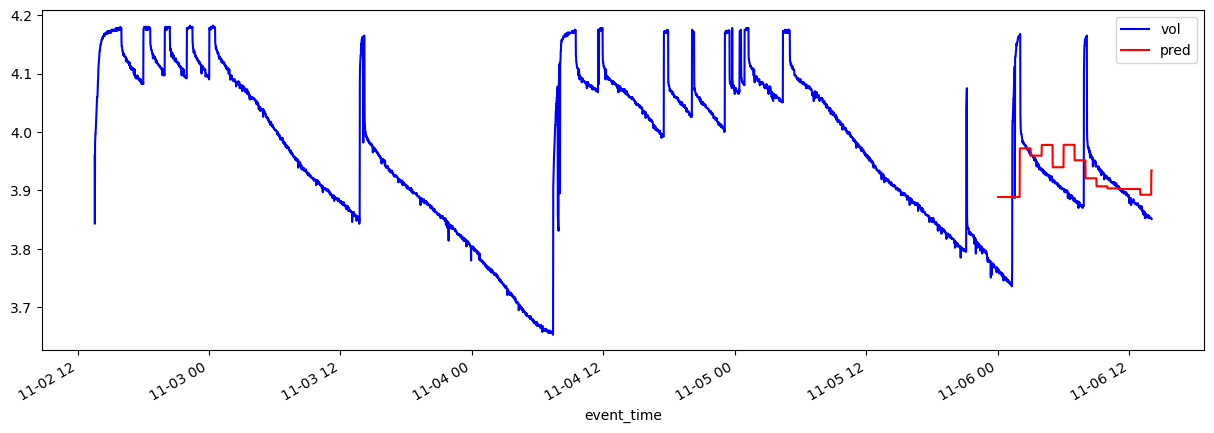

In [59]:
_ = voltage[['vol', 'pred']].plot(figsize=(15, 5), color=['blue', 'red'])

###  Look at first 12 hours of predictions¶

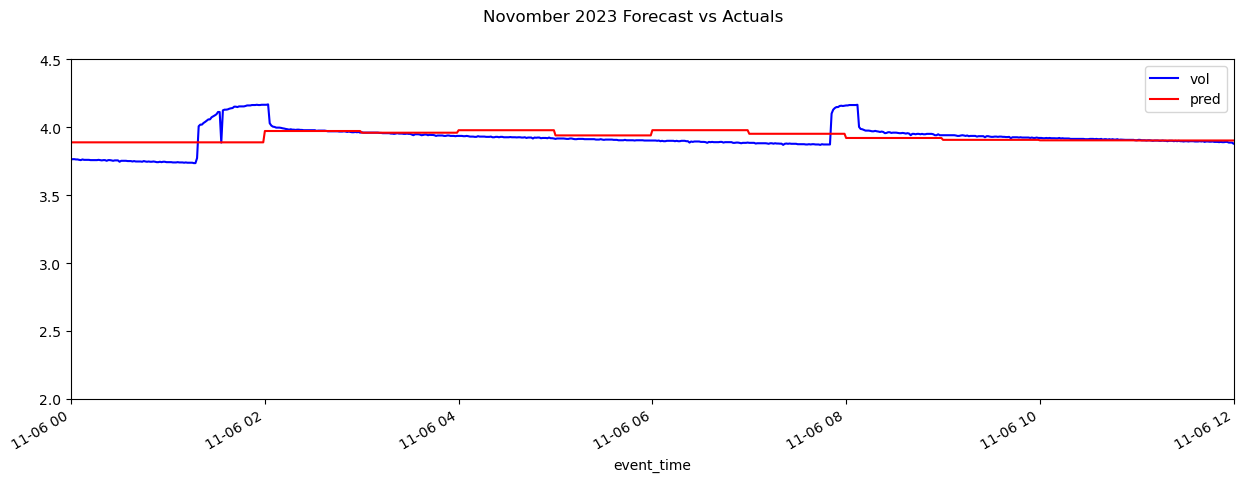

In [60]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = voltage[['vol', 'pred']].plot(ax=ax,
                                style=['-','-'], color=['blue', 'red'])
ax.set_xbound(lower='2024-11-06 00:00:00', upper='2024-11-06 12:00:00')
ax.set_ylim(2, 4.5)
plot = plt.suptitle('Novomber 2023 Forecast vs Actuals')

#### Error Metrics On Test Set

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [62]:
mean_squared_error(y_true=vol_test['vol'],
                   y_pred=vol_test['pred'])

0.006938769583585906

In [63]:
mean_absolute_error(y_true=vol_test['vol'],
                   y_pred=vol_test['pred'])

0.05614539883414818

In [64]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [65]:
mean_absolute_percentage_error(y_true=vol_test['vol'],
                   y_pred=vol_test['pred'])

1.428318462792026

#### Look at Worst and Best Predicted Days

In [66]:
vol_test['error'] = vol_test['vol'] - vol_test['pred']
vol_test['abs_error'] = vol_test['error'].apply(np.abs)
error_by_day = vol_test.groupby(['year','month','dayofmonth']) \
    .mean()[['vol','pred','error','abs_error']]

In [69]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head()

,,,vol,pred,error,abs_error
year,month,dayofmonth,,,,
2024,11,6,3.914297,3.927576,-0.013279,0.056145


In [70]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head()

,,,vol,pred,error,abs_error
year,month,dayofmonth,,,,
2024,11,6,3.914297,3.927576,-0.013279,0.056145


In [71]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

,,,vol,pred,error,abs_error
year,month,dayofmonth,,,,
2024,11,6,3.914297,3.927576,-0.013279,0.056145


#### Plotting some best/worst predicted days

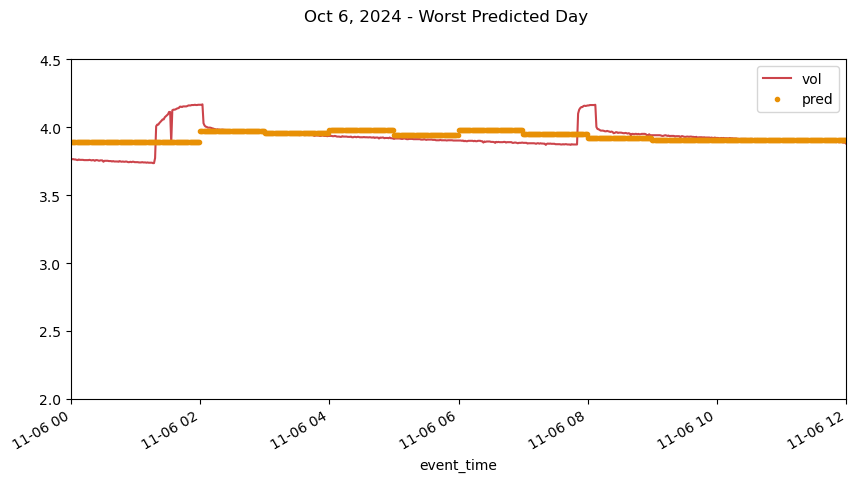

In [72]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = voltage[['vol','pred']].plot(ax=ax,
                                style=['-','.'])
ax.set_ylim(2, 4.5)
ax.set_xbound(lower='2024-11-06 00:00:00', upper='2024-11-06 12:00:00')
plot = plt.suptitle('Oct 6, 2024 - Worst Predicted Day')



In [100]:
# mae = round(mean_absolute_error(df_y_test['vol'], df_y_test['Predicted']), 3)

### Predict the value for next 2 Hours

In [86]:
future_dates = X_test.iloc[-720:, :].copy()
future_dates.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
event_time,,,,,,,,
2024-11-06 02:02:00,2,2,4,11,2024,311,6,45
2024-11-06 02:03:00,2,2,4,11,2024,311,6,45
2024-11-06 02:04:00,2,2,4,11,2024,311,6,45
2024-11-06 02:05:00,2,2,4,11,2024,311,6,45
2024-11-06 02:06:00,2,2,4,11,2024,311,6,45


In [87]:
future_dates['event_time'] = pd.to_datetime(future_dates.index)
future_dates = future_dates.set_index('event_time')

In [88]:
future_dates.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
event_time,,,,,,,,
2024-11-06 02:02:00,2,2,4,11,2024,311,6,45
2024-11-06 02:03:00,2,2,4,11,2024,311,6,45
2024-11-06 02:04:00,2,2,4,11,2024,311,6,45
2024-11-06 02:05:00,2,2,4,11,2024,311,6,45
2024-11-06 02:06:00,2,2,4,11,2024,311,6,45


In [89]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [90]:
pd.DataFrame(X).head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,13,5,4,11,2024,307,2,44
1,13,5,4,11,2024,307,2,44
2,13,5,4,11,2024,307,2,44
3,13,5,4,11,2024,307,2,44
4,13,5,4,11,2024,307,2,44


In [91]:
pd.DataFrame(y).head()

,vol
0,3.96000
1,3.84304
2,3.98004
3,3.99000
4,3.99696


In [92]:
xgb_model2 = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    eval_metric='mae')

xgb_model2.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
future_dates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2024-11-06 02:02:00 to 2024-11-06 14:01:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hour        720 non-null    int32 
 1   dayofweek   720 non-null    int32 
 2   quarter     720 non-null    int32 
 3   month       720 non-null    int32 
 4   year        720 non-null    int32 
 5   dayofyear   720 non-null    int32 
 6   dayofmonth  720 non-null    int32 
 7   weekofyear  720 non-null    UInt32
dtypes: UInt32(1), int32(7)
memory usage: 28.8 KB


In [94]:
xgb_pred2 = xgb_model2.predict(future_dates)

In [95]:
df_plot2 = pd.DataFrame({'time':future_dates['hour'], 'xgb_pred2':xgb_pred2})
df_plot2

,time,xgb_pred2
event_time,,
2024-11-06 02:02:00,2,3.987872
2024-11-06 02:03:00,2,3.987872
2024-11-06 02:04:00,2,3.987872
2024-11-06 02:05:00,2,3.987872
2024-11-06 02:06:00,2,3.987872
...,...,...
2024-11-06 13:57:00,13,3.860282
2024-11-06 13:58:00,13,3.860282
2024-11-06 13:59:00,13,3.860282


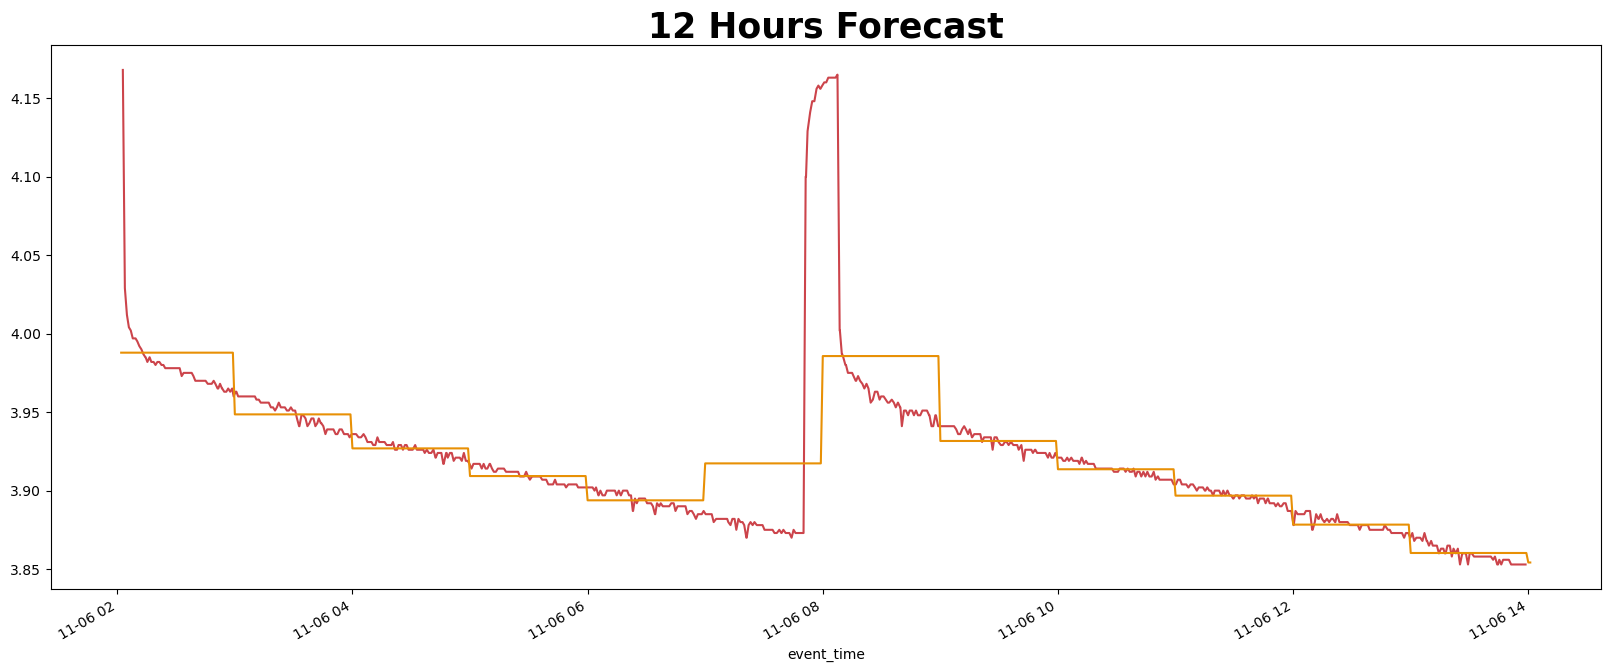

In [96]:
last_12hours = df['2024-11-06 02:02:00' : '2024-11-06 13:59:00']

plt.figure(figsize=(20,8))

last_12hours['vol'].plot()
df_plot2['xgb_pred2'].plot()
plt.title('12 Hours Forecast', weight='bold', fontsize=25)
plt.show()